## Feature Varying Graph

Plots important values as a function of feature number.

#### Import packages and read in pre-processed dataframes/arrays

In [8]:
import sklearn.ensemble
import sklearn.multiclass
import sklearn.model_selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

featureDf = pd.read_pickle('./processed.files/featureDf')
labelledDf = pd.read_pickle('./processed.files/labelledDf')
preProcFeats = np.load('./processed.files/features.npy')
preProcLabels = np.load('./processed.files/labels.npy')

#### Define the k-fold shuffling method and use the RandomForest method to fit the OneVsRest classifier on all of the data

In [3]:
k_fold = sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True)

randForest = sklearn.multiclass.OneVsRestClassifier(sklearn.ensemble.RandomForestClassifier()) #classifier for multiple labels

clf = sklearn.multiclass.OneVsRestClassifier(estimator=sklearn.ensemble.RandomForestClassifier(bootstrap=True, 
            class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=-1,
            oob_score=False, random_state=420, verbose=0,
            warm_start=False),
            n_jobs=1)

fitmodel = clf.fit(preProcFeats, preProcLabels)

#### Iterate over dropping successive features and fitting model

In [5]:
fullfeats = preProcFeats
fulllabels = preProcLabels
threshprob = 0.2

fimps = []
fullarr = []

#Create a list with each element one of the feature importance arrays for one of the estimators:
for idx in np.arange(8):
    importance = fitmodel.estimators_[idx].feature_importances_
    fimps.append(importance)
    
featureidxs = np.array([])
featurenumber = np.array([])
summed9probs = np.array([])
falsenegs = np.array([])

for i in np.arange(50):
    
    #Randomise the seed for the k-fold shuffle
    randstate = np.random.randint(1,1000)
    
    #Append next highest importance features to new features array & replace importance with 0:
    for idx in np.arange(8):
        fimp = fimps[idx]
        maxargs = np.argmax(fimp)
        maxargs = maxargs.astype(int)
        featureidxs = np.append(featureidxs, maxargs).astype(int)
        fimp[maxargs] = 0
        fimps[idx] = fimp
    
    #Make sure no feature indices are repeated & create new feature list:
    featureidxs = np.unique(featureidxs).astype(int)
    allidx = np.arange(fullfeats.shape[1]).astype(int)
    delfeats = np.delete(allidx, featureidxs).astype(int)
    features = np.delete(fullfeats, delfeats, axis=1).astype(int)
    
    #If maximum number of features has already been reached, break the for loop:
    if features[1].size == 300:
        print '300 features reached'
        break
    
    #Save the # of features for this iteration
    featurenumber = np.append(featurenumber, features.shape[1])
    featurenumber = featurenumber.astype(int)
    #print '# of features: %d' %(features.shape[1])
    
    
    #Train the model with new list of features:
    xtrain, xtest, ytrain, ytest = sklearn.model_selection.train_test_split(features,\
                                                            fulllabels, test_size=0.25, random_state=randstate)
    trainedmodel = clf.fit(xtrain, ytrain)
    
    #Predict probabilities for each known pulsar time series:
    args9 = np.argwhere(ytest == 9).astype(int)
    args9 = args9.flatten()
    prediction = trainedmodel.predict_proba(xtest)
    is9 = prediction[args9]
    
        
    #Sum all predicted probabilities of being in class 9 for time series labelled with 9:
    probs9is9 = is9[:,7]
    falseneg = np.argwhere(probs9is9 < threshprob).size
    #print '# of false negatives: %d' %falseneg
    falsenegs = np.append(falsenegs, falseneg)
    prob9sum = np.sum(probs9is9)
    prob9sum /= args9.size
    summed9probs = np.append(summed9probs, prob9sum)
    
print 'number of data points: %d' %(featurenumber.size)

number of data points: 50


## Plot graphs of variables

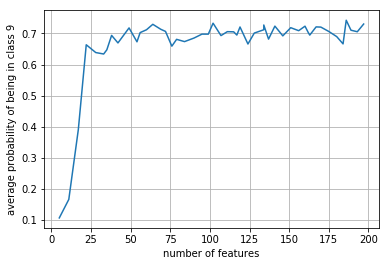

In [6]:
plt.plot(featurenumber, summed9probs)
plt.ylabel('average probability of being in class 9')
plt.xlabel('number of features')
plt.grid(True)
plt.savefig('feature.importance.graphs/avgprob.png')
plt.show()

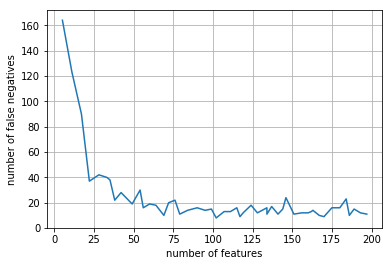

In [7]:
plt.plot(featurenumber, falsenegs)
plt.ylabel('number of false negatives')
plt.xlabel('number of features')
plt.grid(True)
plt.savefig('feature.importance.graphs/falsenegs.png')
plt.show()